## The objective of this analysis file is to group the buoys by Machine Learning methods

###  In our dataset, each observation (row) has been generated by one buoy. However, the dataset doesn't provide information that relates each observation with the buoy that has created it. The only hint provided is that all observations came from roughly 70 buoys. 

### Nevertheless, the information about the latitude and longitude of each observation give us the possibility to group the observations made by location, and then, extrapolate that each different location corresponds to a different buoy. 

### Import libraries

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import cufflinks as cf
cf.go_offline()

from sklearn.cluster import DBSCAN
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import silhouette_score
from sklearn.metrics import make_scorer

### Check the data

In [3]:
data = pd.read_csv('../Data/enso_data_cleaned.csv')
data['date'] = pd.to_datetime(data['date'])

In [4]:
data.head()

,obs,year,month,day,date,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.
0,1,1980,3,7,1980-03-07,-0.02,-109.46,-6.8,0.7,NaN,26.14,26.24
1,2,1980,3,8,1980-03-08,-0.02,-109.46,-4.9,1.1,NaN,25.66,25.97
2,3,1980,3,9,1980-03-09,-0.02,-109.46,-4.5,2.2,NaN,25.69,25.28
3,4,1980,3,10,1980-03-10,-0.02,-109.46,-3.8,1.9,NaN,25.57,24.31
4,5,1980,3,11,1980-03-11,-0.02,-109.46,-4.2,1.5,NaN,25.30,23.19


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178080 entries, 0 to 178079
Data columns (total 12 columns):
obs          178080 non-null int64
year         178080 non-null int64
month        178080 non-null int64
day          178080 non-null int64
date         178080 non-null datetime64[ns]
latitude     178080 non-null float64
longitude    178080 non-null float64
zon.winds    152917 non-null float64
mer.winds    152918 non-null float64
humidity     112319 non-null float64
air temp.    159843 non-null float64
s.s.temp.    161073 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(4)
memory usage: 16.3 MB


### We use DBSCAN method from sklearn to cluster our observations. 
### Each cluster will correspond to one different buoy.

#### We will cluster the observations in base of their location. Thus, we define X with the longitude and latitude.

In [6]:
data['epoch_time'] = data['date'].apply(lambda x: (pd.Timestamp(x) - pd.Timestamp("1970-01-01"))//pd.Timedelta('1s'))

In [7]:
X = data[['latitude', 'longitude' , 'year']].sample(100000)

#### We set the most important parameters.

In [39]:
eps = 1.8
# The maximum distance between two samples for them to be considered as in the same neighborhood.

min_samples = 100
# The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

n_jobs = -1
# The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.

#### We initialize and fit the model

In [40]:
dbs = DBSCAN(eps = eps, min_samples= min_samples, n_jobs= n_jobs)
dbs.fit(X)

DBSCAN(algorithm='auto', eps=1.8, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=-1, p=None)

#### We evaluate the model using the Silhouette score.

In [41]:
# A silhouette score ranges from -1 to 1, with -1 being the worst score possible and 1 being the best score. Silhouette scores of 0 suggest overlapping clusters.
# silhouette_score(X, dbs.labels_, sample_size= 50000)

#### We add the labels from DBSCAN to a new column in the dataset.

In [42]:
X['buoy_label'] = dbs.labels_

In [43]:
len(X['buoy_label'].unique())

65

In [44]:
X['buoy_label'].value_counts().tail()

 61    284
 54    265
 62    243
 59    218
-1      70
Name: buoy_label, dtype: int64

In [45]:
X['buoy_label'].value_counts().head()

10    8319
15    5643
12    4873
16    4532
31    3443
Name: buoy_label, dtype: int64

#### We plot the coordinates together with the label.

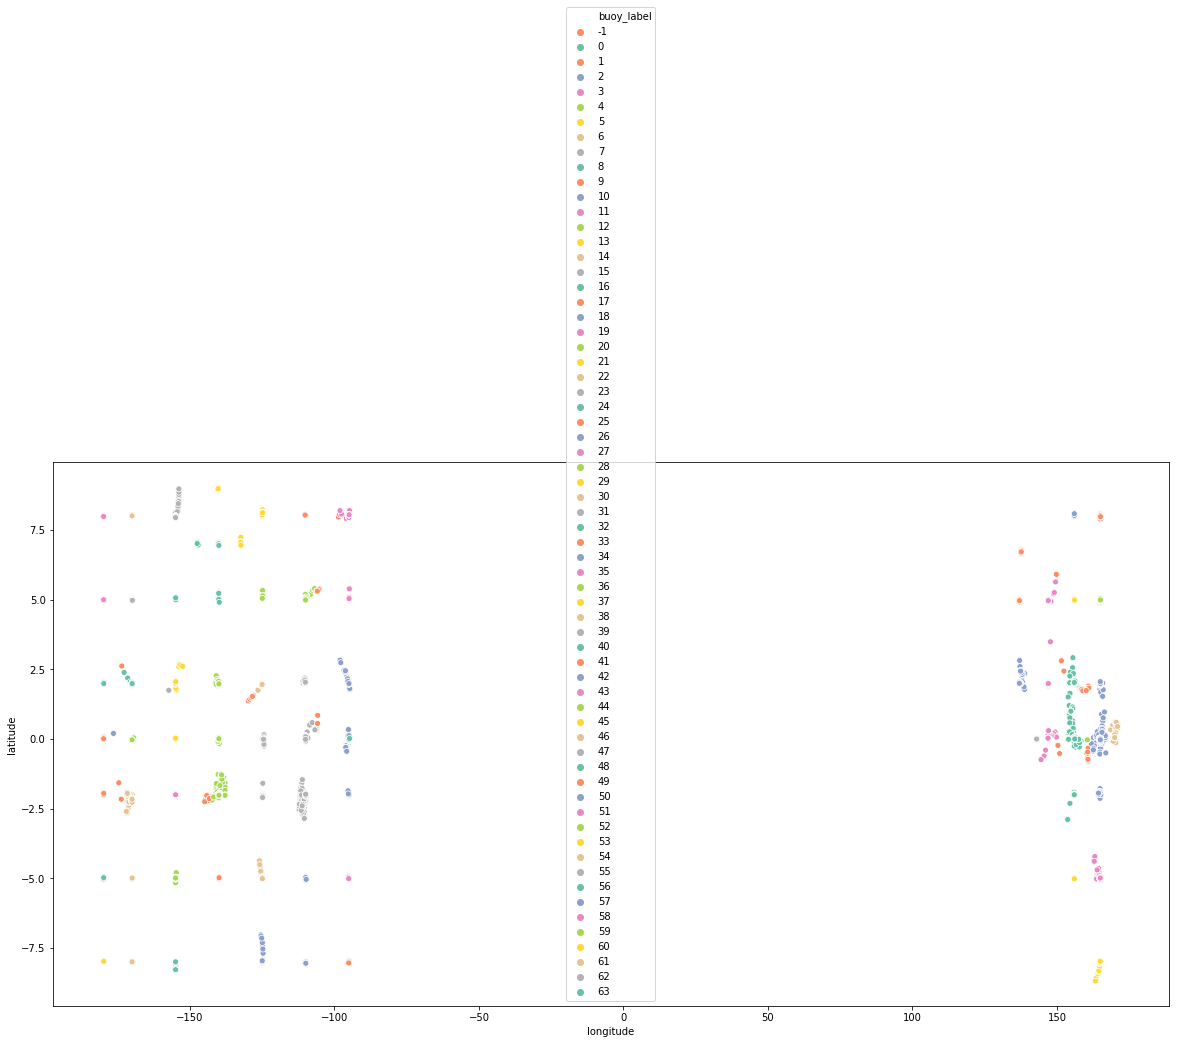

In [46]:
location = X[['latitude', 'longitude', 'buoy_label']]

x = location['longitude']
y = location['latitude']
hue = location['buoy_label']


###plot

fig, ax = plt.subplots(figsize=(20, 10))

# Label to each color
color_labels = hue.unique()

# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color = dict(zip(color_labels, rgb_values))


sns.scatterplot(x, y,  hue = hue, palette = color, legend= 'full')

#### Conclusion: I cannot fit any parameter combination in the DBSCAN so all groups are well defined. The reason for this is that the shapes of the groups are very different plus there are so many groups to classify. 
#### In order to perform a perfect group clustering I should divide the data into groups and run the analysis for each group. However, as it is not the main focus of my project, I'll leave it.

#### Other options are:
- Try another unsupervised method for clustering.
- Take into account more dimensions.

### Now, I will focus only in clustering the data from 4.0 to 6.0 N, because all observations in that latitude seems that are well grouped.

In [47]:
data.head()

,obs,year,month,day,date,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.,epoch_time
0,1,1980,3,7,1980-03-07,-0.02,-109.46,-6.8,0.7,NaN,26.14,26.24,321235200
1,2,1980,3,8,1980-03-08,-0.02,-109.46,-4.9,1.1,NaN,25.66,25.97,321321600
2,3,1980,3,9,1980-03-09,-0.02,-109.46,-4.5,2.2,NaN,25.69,25.28,321408000
3,4,1980,3,10,1980-03-10,-0.02,-109.46,-3.8,1.9,NaN,25.57,24.31,321494400
4,5,1980,3,11,1980-03-11,-0.02,-109.46,-4.2,1.5,NaN,25.30,23.19,321580800


In [48]:
data.shape

(178080, 13)

In [49]:
X_5 = data[(data['latitude'] < 6) & (data['latitude'] > 4)][['latitude', 'longitude' , 'year']]

In [50]:
X_5.shape

(26946, 3)

(1257, 3)


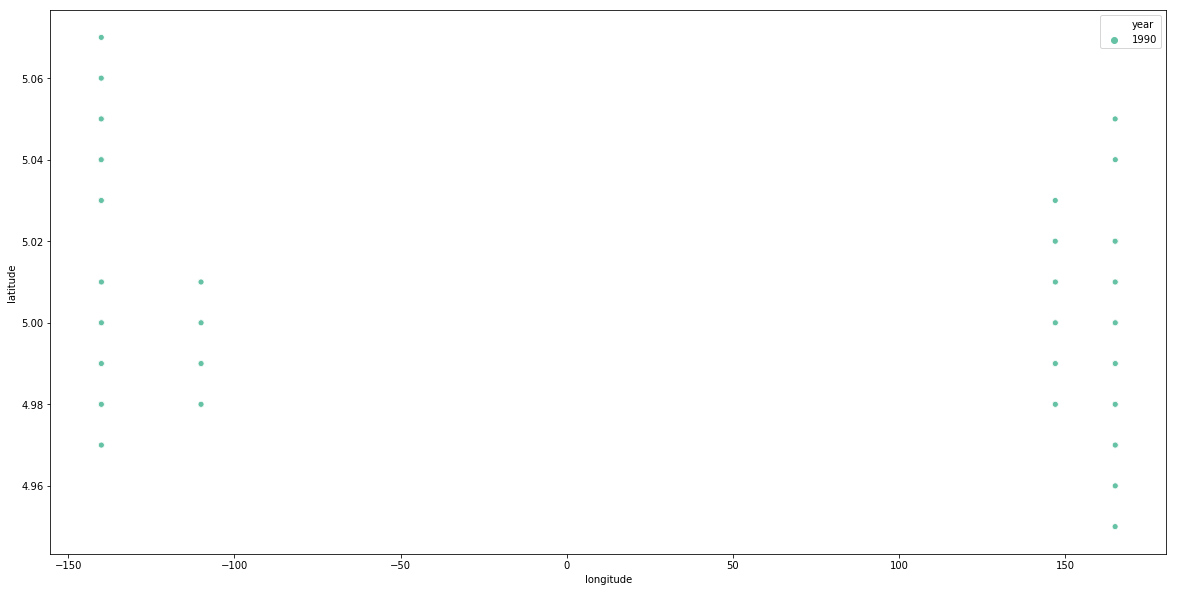

In [51]:
X_5 = data[(data['latitude'] < 6) & (data['latitude'] > 4) & (data['year'] == 1990)][['latitude', 'longitude' , 'year']]
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(x = X_5['longitude'], y = X_5 ['latitude'], hue=X_5['year'], palette = 'Set2', legend= 'full')
print(X_5.shape)

#### We use DBSCAN method from sklearn to cluster our observations. 
#### Each cluster will correspond to one different buoy.

#### We set the most important parameters.

In [52]:
eps_5 = 3.0
# The maximum distance between two samples for them to be considered as in the same neighborhood.

min_samples_5 = 120
# The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

n_jobs_5 = -1
# The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.

#### We initialize and fit the model

In [53]:
dbs_5 = DBSCAN(eps = eps, min_samples= min_samples, n_jobs= n_jobs)
dbs_5.fit(X_5)

DBSCAN(algorithm='auto', eps=1.8, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=100, n_jobs=-1, p=None)

#### We evaluate the model using the Silhouette score.

In [54]:
# A silhouette score ranges from -1 to 1, with -1 being the worst score possible and 1 being the best score. Silhouette scores of 0 suggest overlapping clusters.
# silhouette_score(X_5, dbs_5.labels_, sample_size= 50000)

#### We add the labels from DBSCAN to a new column in the dataset.

In [55]:
X_5['buoy_label'] = dbs_5.labels_

In [56]:
len(X_5['buoy_label'].unique())

4

In [57]:
X_5['buoy_label'].value_counts().tail()

0    365
3    330
2    316
1    246
Name: buoy_label, dtype: int64

In [58]:
X_5['buoy_label'].value_counts().head()

0    365
3    330
2    316
1    246
Name: buoy_label, dtype: int64

#### We plot the coordinates together with the label.

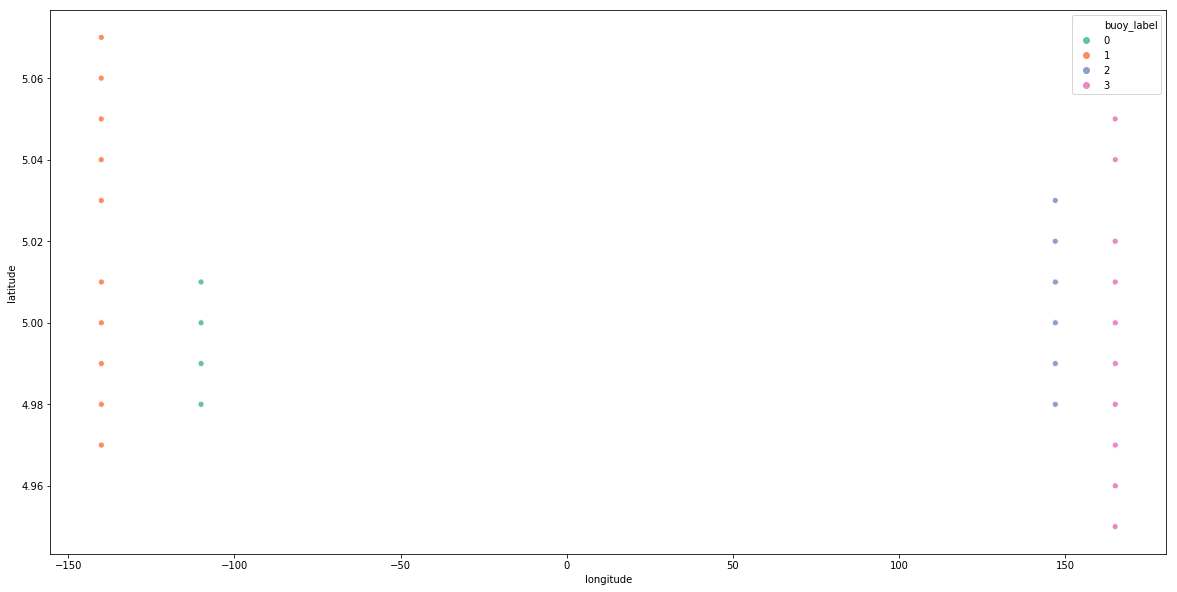

In [59]:
location = X_5[['latitude', 'longitude', 'buoy_label']]

x = location['longitude']
y = location['latitude']
hue = location['buoy_label']


###plot

fig, ax = plt.subplots(figsize=(20, 10))

# Label to each color
color_labels = hue.unique()

# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color = dict(zip(color_labels, rgb_values))


sns.scatterplot(x, y,  hue = hue, palette = color, legend= 'full')

### We analyze the new clustered data

In [60]:
data_5N = data[(data['latitude'] < 6) & (data['latitude'] > 4)]
data_5N['buoy_label'] = X_5['buoy_label']

In [61]:
data_5N.isna().sum()

obs               0
year              0
month             0
day               0
date              0
latitude          0
longitude         0
zon.winds      4712
mer.winds      4712
humidity       9466
air temp.      1740
s.s.temp.      1413
epoch_time        0
buoy_label    25689
dtype: int64

In [62]:
data_5N.shape

(26946, 14)

In [63]:
data_5N[data_5N['date'] > '1984-01-01'].head()

,obs,year,month,day,date,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.,epoch_time,buoy_label
93184,93185,1985,11,9,1985-11-09,5.00,-110.00,NaN,NaN,NaN,23.93,26.48,500342400,NaN
93185,93186,1985,11,10,1985-11-10,5.00,-110.00,NaN,NaN,NaN,25.26,26.48,500428800,NaN
93186,93187,1985,11,11,1985-11-11,5.06,-110.02,NaN,NaN,NaN,25.01,26.45,500515200,NaN
93187,93188,1985,11,12,1985-11-12,5.06,-110.02,NaN,NaN,NaN,24.99,26.52,500601600,NaN
93188,93189,1985,11,13,1985-11-13,5.05,-110.01,NaN,NaN,NaN,25.11,26.55,500688000,NaN


In [64]:
data_5N_x = data_5N.groupby(by=['date']).mean()

In [65]:
data_5N_x.isna().sum()

obs              0
year             0
month            0
day              0
latitude         0
longitude        0
zon.winds      227
mer.winds      227
humidity      1738
air temp.       24
s.s.temp.      184
epoch_time       0
buoy_label    4083
dtype: int64

In [66]:
data_5N_x[data_5N_x["s.s.temp."].isnull()]

,obs,year,month,day,latitude,longitude,zon.winds,mer.winds,humidity,air temp.,s.s.temp.,epoch_time,buoy_label
date,,,,,,,,,,,,,
1985-12-23,93229.000000,1985.0,12.0,23.0,5.050000,-110.02,NaN,NaN,NaN,NaN,NaN,504144000.0,NaN
1985-12-31,93237.000000,1985.0,12.0,31.0,5.050000,-110.03,NaN,NaN,NaN,NaN,NaN,504835200.0,NaN
1986-01-12,93249.000000,1986.0,1.0,12.0,5.050000,-110.02,NaN,NaN,NaN,NaN,NaN,505872000.0,NaN
1986-01-31,93268.000000,1986.0,1.0,31.0,5.060000,-110.01,NaN,NaN,NaN,NaN,NaN,507513600.0,NaN
1986-03-14,93310.000000,1986.0,3.0,14.0,5.050000,-110.02,NaN,NaN,NaN,NaN,NaN,511142400.0,NaN
1986-03-15,93311.000000,1986.0,3.0,15.0,5.050000,-110.02,NaN,NaN,NaN,NaN,NaN,511228800.0,NaN
1986-06-01,93389.000000,1986.0,6.0,1.0,5.060000,-110.01,NaN,NaN,NaN,NaN,NaN,517968000.0,NaN
1986-06-02,93390.000000,1986.0,6.0,2.0,5.060000,-110.01,NaN,NaN,NaN,NaN,NaN,518054400.0,NaN
1986-06-03,93391.000000,1986.0,6.0,3.0,5.000000,-110.00,NaN,NaN,NaN,NaN,NaN,518140800.0,NaN


In [67]:

data_5N_x[['mer.winds']].iplot(kind='line', xTitle='Time',
           yTitle='Air/Sea Temperature (ºC)', title='Air and set temperature between 1980 and  1998')

#### We copy the well assigned observations to a new .csv.

In [69]:
data_5N.to_csv('../Data/obs_5N_labelled.csv')